In [25]:
import os
import datetime as dt
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

SUPABASE_URL = os.environ.get("SUPABASE_URL")
SUPABASE_KEY = (
    os.environ.get("SUPABASE_SERVICE_ROLE_KEY")
    or os.environ.get("SUPABASE_API_KEY")
    or os.environ.get("SUPABASE_ANON_KEY")
)

if not SUPABASE_URL or not SUPABASE_KEY:
    raise RuntimeError("Set SUPABASE_URL and SUPABASE_KEY in environment.")

In [26]:
def fetch_macro_state_daily(start_date: dt.date, end_date: dt.date) -> pd.DataFrame:
    endpoint = f"{SUPABASE_URL}/rest/v1/macro_state_daily"
    headers = {
        "apikey": SUPABASE_KEY,
        "Authorization": f"Bearer {SUPABASE_KEY}",
    }
    params_base = {
        "select": ",".join(
            [
                "date",
                "regime_id",
                "regime_label",
                "stress_score",
                "hmm_score_raw",
                "hmm_score_0_100",
                "prob_state_0",
                "prob_state_1",
                "prob_state_2",
                "prob_state_3",
                "skew",
                "vix",
                "sofr_minus_iorb",
            ]
        ),
        "date": [f"gte.{start_date.isoformat()}", f"lte.{end_date.isoformat()}"],
        "order": "date.asc",
        "limit": 1000,
    }

    rows = []
    offset = 0
    while True:
        params = params_base.copy()
        params["offset"] = offset
        resp = requests.get(endpoint, headers=headers, params=params, timeout=30)
        resp.raise_for_status()
        batch = resp.json()
        rows.extend(batch)
        if len(batch) < 1000:
            break
        offset += 1000

    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"])
    
    # Convert numeric columns
    cols = ["stress_score", "hmm_score_raw", "hmm_score_0_100", "skew", "sofr_minus_iorb"]
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            
    return df

In [27]:
end = dt.date.today()
start = end - dt.timedelta(days=360*2)

macro = fetch_macro_state_daily(start, end)
macro.tail()

date  regime_id regime_label  stress_score  hmm_score_raw  \
503 2026-01-19          4    Recession      0.000000      -0.135144   
504 2026-01-20          4    Recession      0.547401      -0.284548   
505 2026-01-21          4    Recession      0.000000      -0.135147   
506 2026-01-22          4    Recession      0.000000      -0.135141   
507 2026-01-23          4    Recession      0.000000      -0.135146   

     hmm_score_0_100  prob_state_0  prob_state_1  prob_state_2  prob_state_3  \
503        99.999448  4.884994e-07  2.779036e-06  1.233611e-05      0.999984   
504        77.347816  1.833304e-02  1.300691e-02  9.686600e-01      0.000000   
505        99.999081  6.662481e-07  4.528581e-06  2.105556e-05      0.999974   
506        99.999998  3.404871e-09  5.604655e-09  5.806843e-08      1.000000   
507        99.999168  8.865209e-07  8.094253e-06  6.445896e-07      0.999990   

           skew    vix  sofr_minus_iorb  
503  153.589996  15.86             0.00  
504  154.960007  20.09            -0.01  
505  144.410004  16.90            -0.02  
506  141.309998  15.64            -0.01  
507  144.020004  16.09            -0.01

In [28]:
# fetch SPX (^GSPC) and align
# Using multi_level_index=False to avoid MultiIndex columns (yfinance >= 0.2)
spx = yf.download(
    "^GSPC", 
    start=start.isoformat(), 
    end=(end + dt.timedelta(days=1)).isoformat(), 
    progress=False,
    multi_level_index=False
)

spx = spx.rename(columns=str.lower)
spx = spx[["close"]].reset_index()
spx["date"] = pd.to_datetime(spx["Date"] if "Date" in spx.columns else spx["date"])
spx = spx[["date", "close"]].set_index("date").sort_index()

# normalize SPX to 100 at start
spx["spx_norm"] = 100.0 * spx["close"] / spx["close"].iloc[0]

if "date" in macro.columns:
    macro_indexed = macro.set_index("date").sort_index()
else:
    macro_indexed = macro.sort_index()
    
df = macro_indexed.join(spx[["spx_norm"]], how="inner")

df.tail()

regime_id regime_label  stress_score  hmm_score_raw  \
date                                                              
2026-01-16          4    Recession      0.000000      -0.135141   
2026-01-20          4    Recession      0.547401      -0.284548   
2026-01-21          4    Recession      0.000000      -0.135147   
2026-01-22          4    Recession      0.000000      -0.135141   
2026-01-23          4    Recession      0.000000      -0.135146   

            hmm_score_0_100  prob_state_0  prob_state_1  prob_state_2  \
date                                                                    
2026-01-16        99.999998  3.600901e-09  3.603776e-09  6.348781e-08   
2026-01-20        77.347816  1.833304e-02  1.300691e-02  9.686600e-01   
2026-01-21        99.999081  6.662481e-07  4.528581e-06  2.105556e-05   
2026-01-22        99.999998  3.404871e-09  5.604655e-09  5.806843e-08   
2026-01-23        99.999168  8.865209e-07  8.094253e-06  6.445896e-07   

            prob_state_3        skew    vix  sofr_minus_iorb    spx_norm  
date                                                                      
2026-01-16      1.000000  153.589996  15.86             0.00  138.782983  
2026-01-20      0.000000  154.960007  20.09            -0.01  135.920340  
2026-01-21      0.999974  144.410004  16.90            -0.02  137.495350  
2026-01-22      1.000000  141.309998  15.64            -0.01  138.249856  
2026-01-23      0.999990  144.020004  16.09            -0.01  138.295045

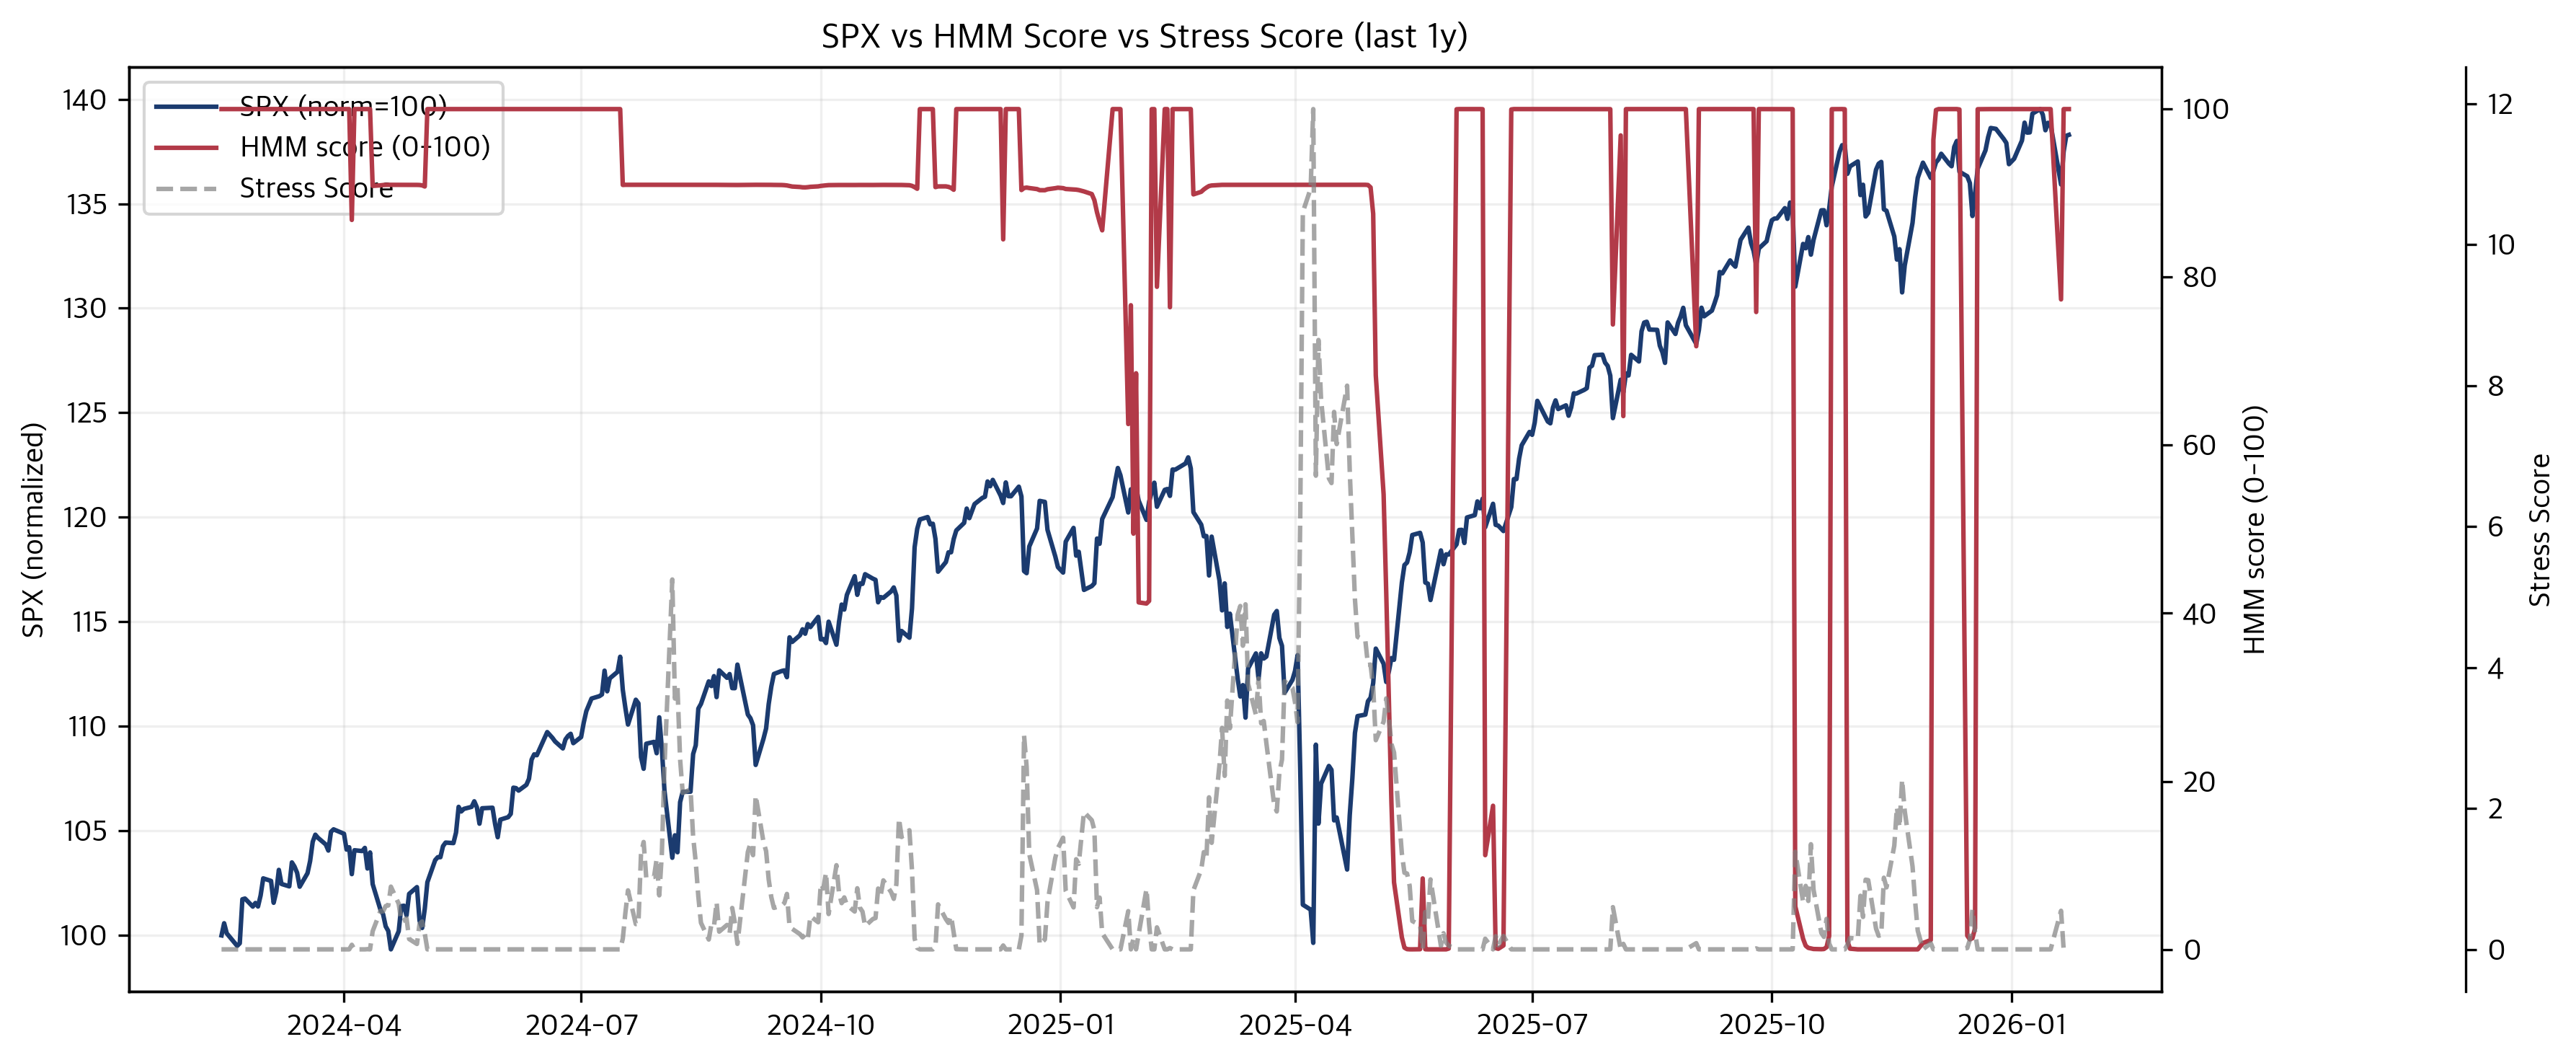

In [29]:
# plot SPX vs HMM score vs Stress Score
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df.index, df["spx_norm"], color="#1b3b6f", label="SPX (norm=100)")
ax1.set_ylabel("SPX (normalized)")
ax1.set_title("SPX vs HMM Score vs Stress Score (last 1y)")
ax1.grid(True, alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(df.index, df["hmm_score_0_100"], color="#b23a48", label="HMM score (0-100)")
ax2.set_ylabel("HMM score (0-100)")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(df.index, df["stress_score"], color="gray", linestyle="--", label="Stress Score", alpha=0.7)
ax3.set_ylabel("Stress Score")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="upper left")

plt.tight_layout()
plt.show()

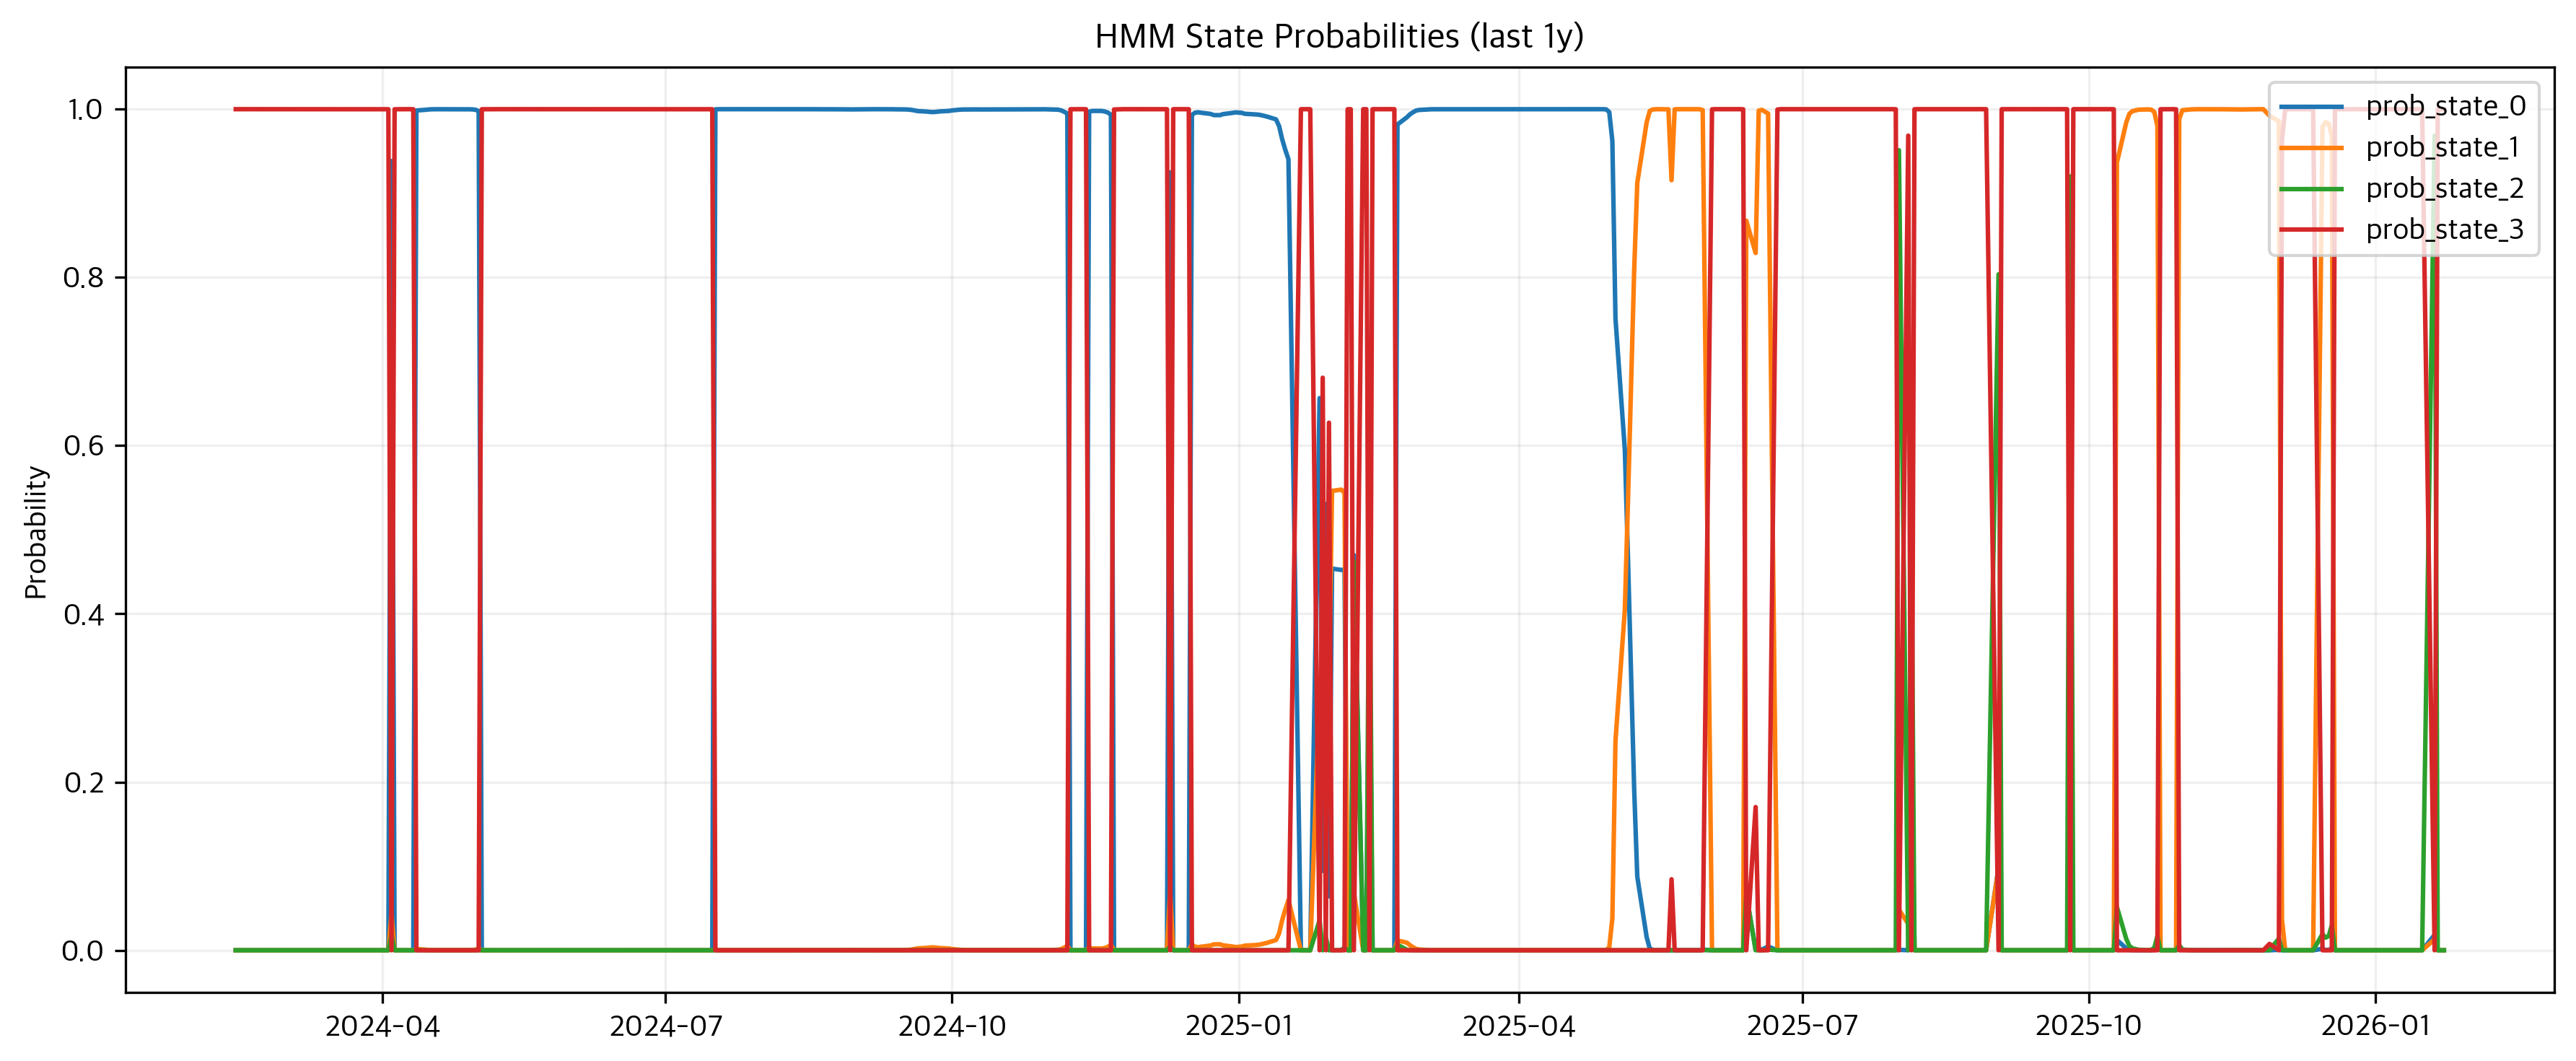

In [30]:
# plot prob_state lines
plt.figure(figsize=(12, 5))
for k in range(4):
    col = f"prob_state_{k}"
    if col in df.columns:
        plt.plot(df.index, df[col], label=col)

plt.title("HMM State Probabilities (last 1y)")
plt.ylabel("Probability")
plt.grid(True, alpha=0.2)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

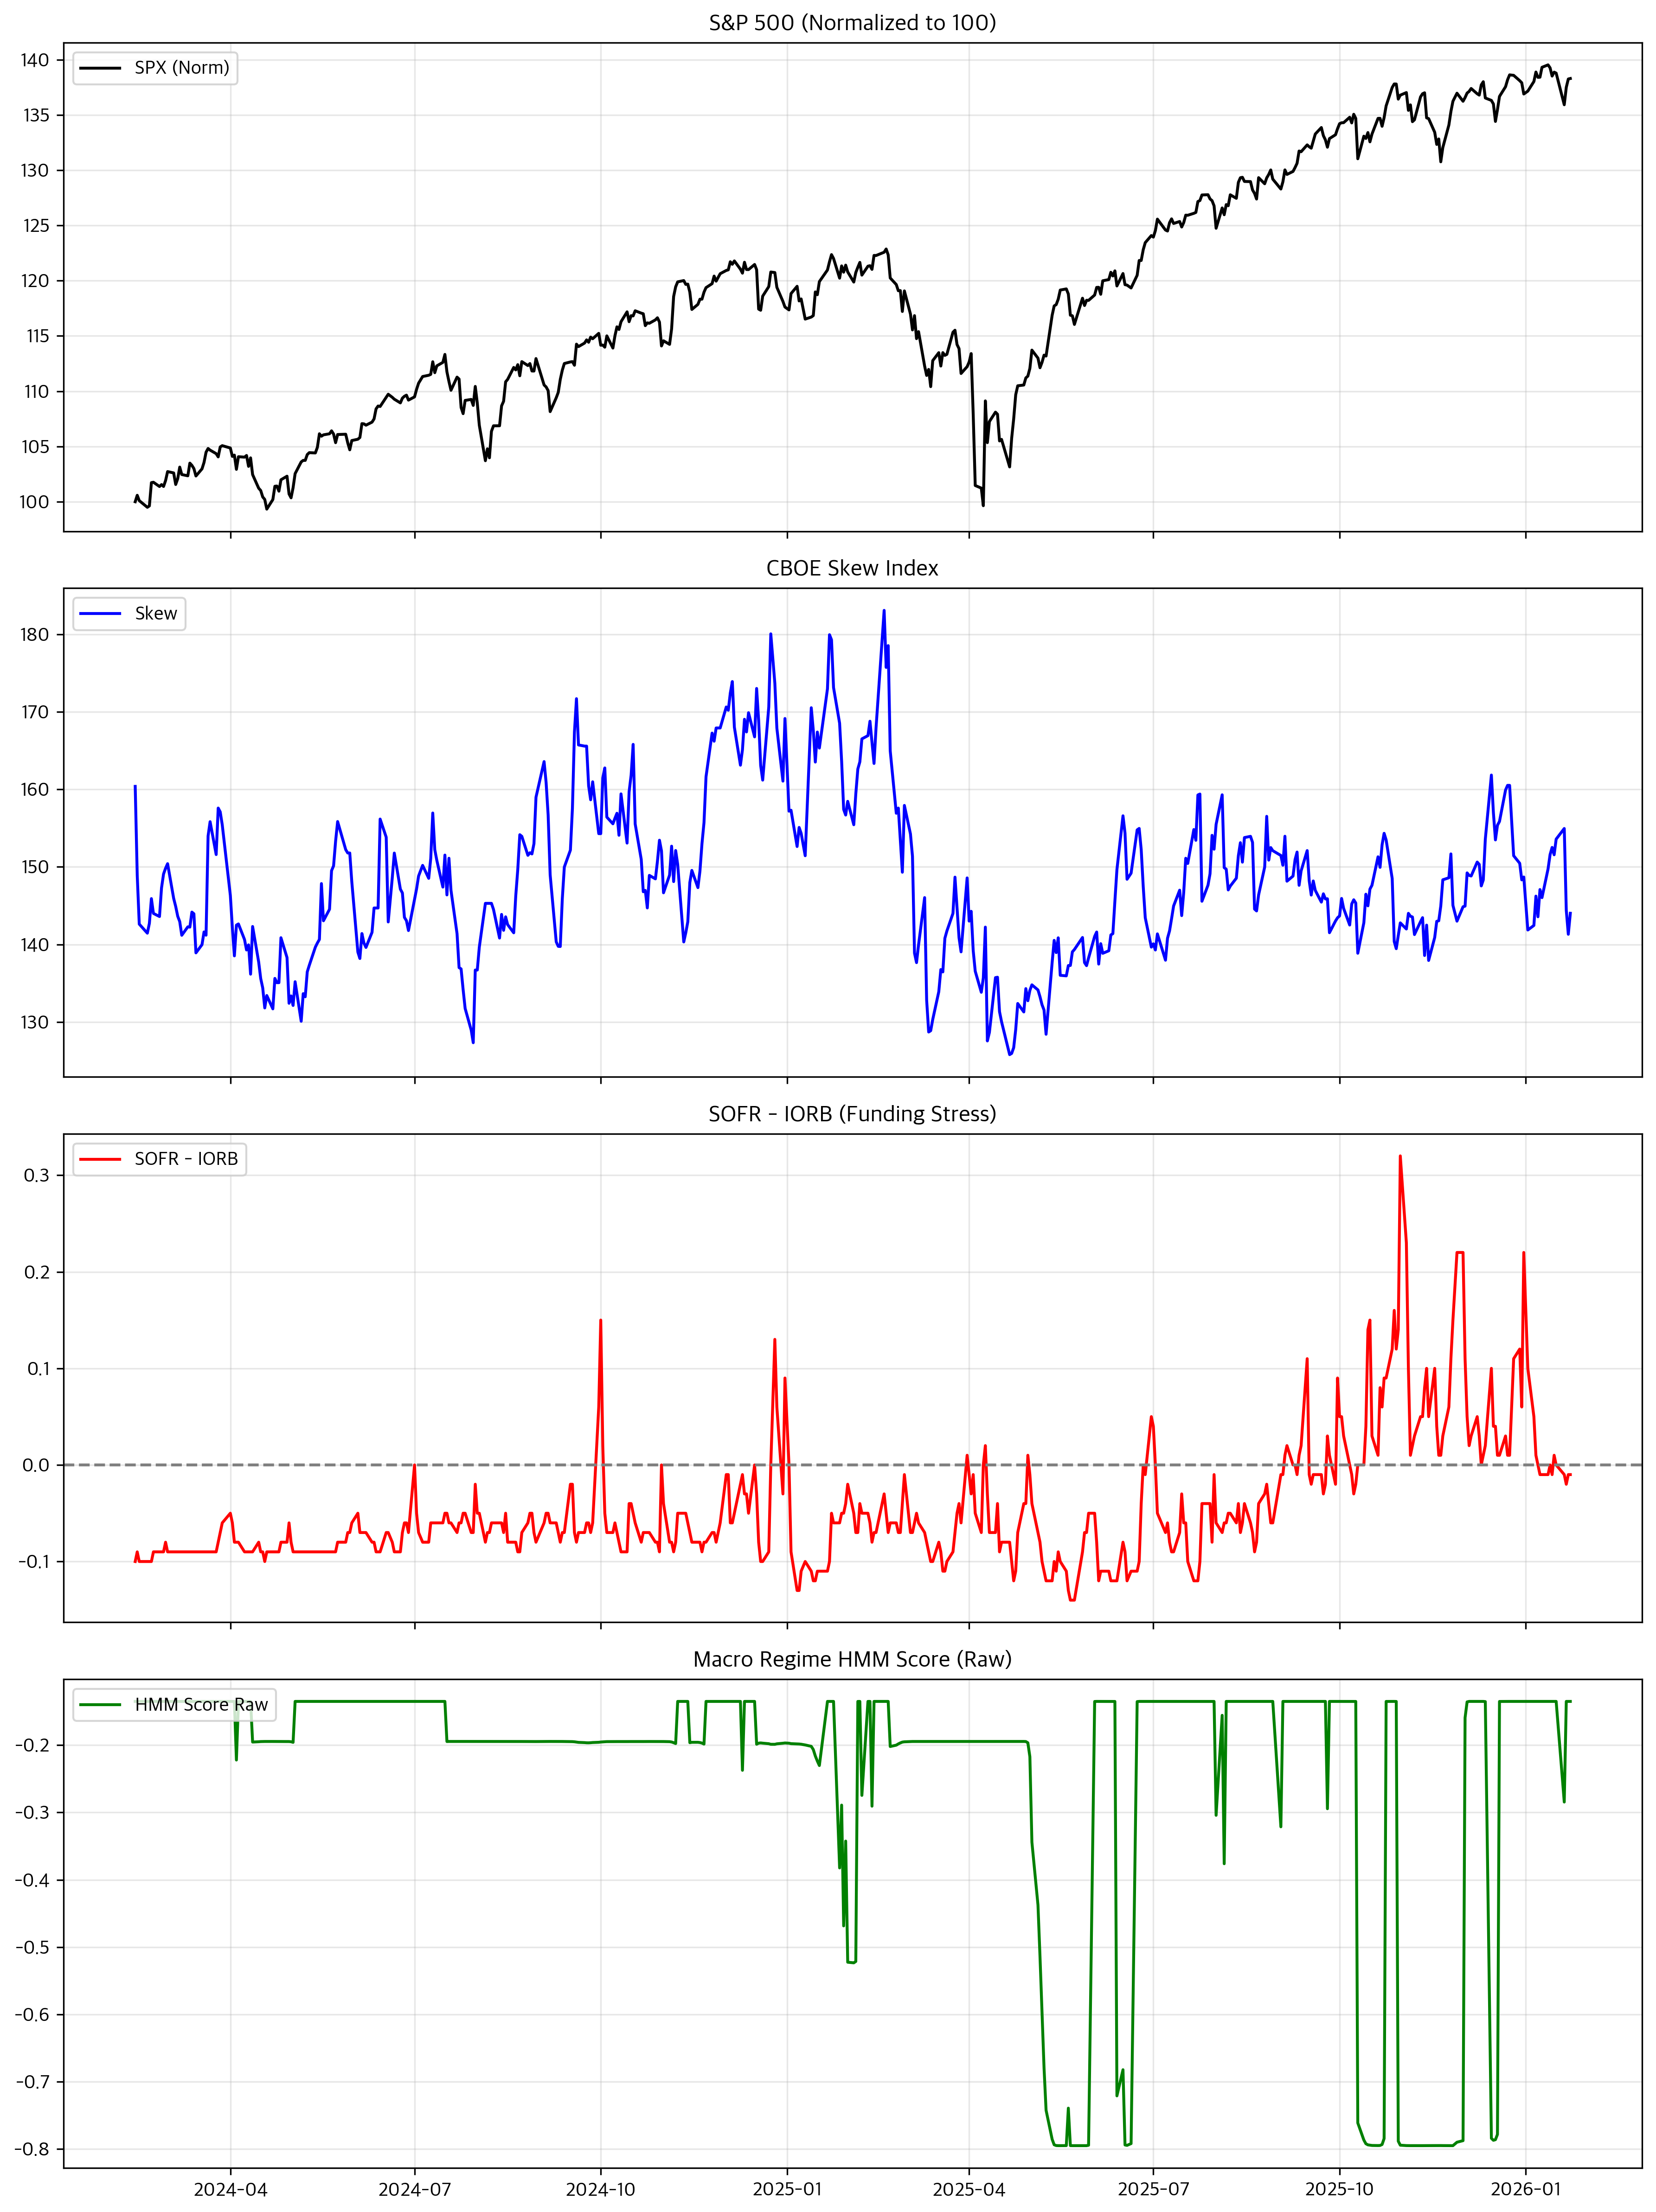

In [31]:
import matplotlib.pyplot as plt

# Ensure aligned data
if "hmm_score_raw" not in df.columns:
    print("Warning: New columns not found in df. Please re-run the fetch and join cells.")
else:
    fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

    # 1. SPX
    axes[0].plot(df.index, df["spx_norm"], label="SPX (Norm)", color="black", linewidth=1.5)
    axes[0].set_title("S&P 500 (Normalized to 100)")
    axes[0].legend(loc="upper left")
    axes[0].grid(True, alpha=0.3)

    # 2. Skew
    if "skew" in df.columns:
        axes[1].plot(df.index, df["skew"], label="Skew", color="blue")
        axes[1].set_title("CBOE Skew Index")
        axes[1].legend(loc="upper left")
        axes[1].grid(True, alpha=0.3)

    # 3. SOFR - IORB
    if "sofr_minus_iorb" in df.columns:
        axes[2].plot(df.index, df["sofr_minus_iorb"], label="SOFR - IORB", color="red")
        axes[2].set_title("SOFR - IORB (Funding Stress)")
        axes[2].axhline(0, color="gray", linestyle="--")
        axes[2].legend(loc="upper left")
        axes[2].grid(True, alpha=0.3)

    # 4. HMM Score Raw
    if "hmm_score_raw" in df.columns:
        axes[3].plot(df.index, df["hmm_score_raw"], label="HMM Score Raw", color="green")
        axes[3].set_title("Macro Regime HMM Score (Raw)")
        axes[3].legend(loc="upper left")
        axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

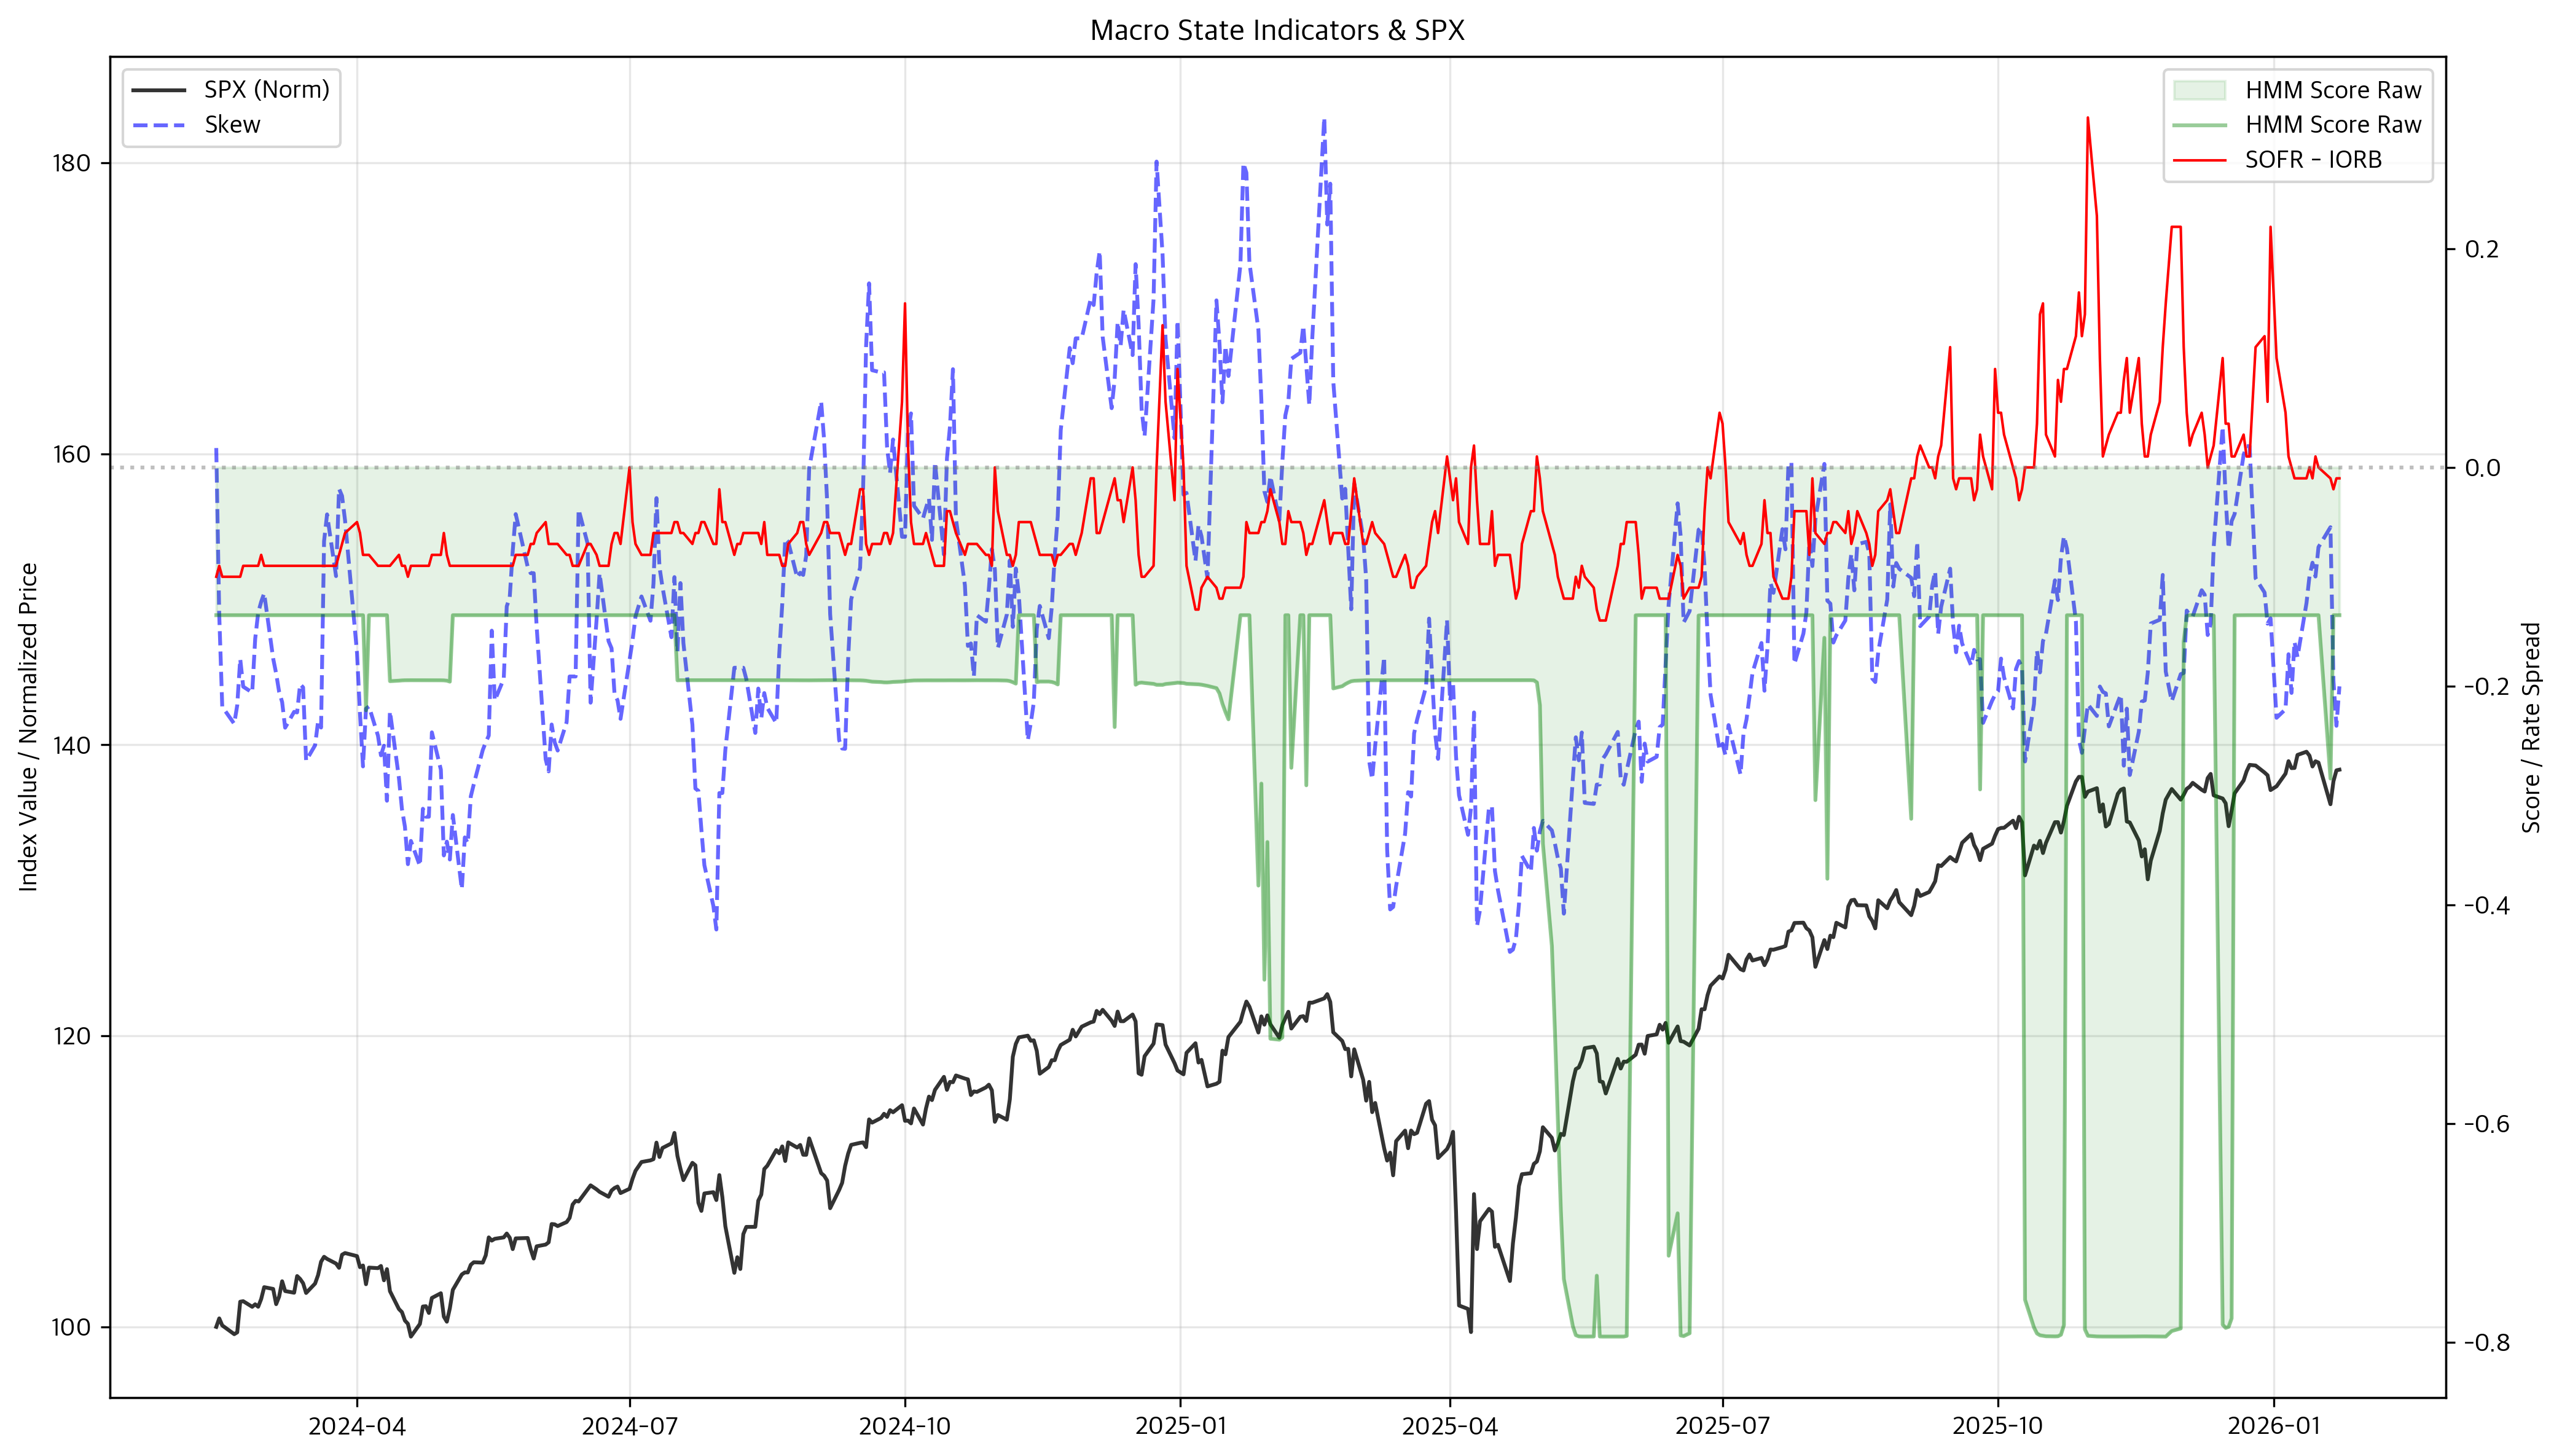

In [32]:
import matplotlib.pyplot as plt

# Ensure aligned data
if "hmm_score_raw" not in df.columns:
    print("Warning: New columns not found in df. Please re-run the fetch and join cells.")
else:
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Ax1: SPX and Skew (Index levels)
    ax1.plot(df.index, df["spx_norm"], label="SPX (Norm)", color="black", linewidth=1.5, alpha=0.8)
    if "skew" in df.columns:
        ax1.plot(df.index, df["skew"], label="Skew", color="blue", alpha=0.6, linestyle='--')
    
    ax1.set_ylabel("Index Value / Normalized Price")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Ax2: Score and Rates (Secondary Axis)
    ax2 = ax1.twinx()
    if "hmm_score_raw" in df.columns:
        # Use area fill for HMM Score to distinguish
        ax2.fill_between(df.index, df["hmm_score_raw"], label="HMM Score Raw", color="green", alpha=0.1)
        ax2.plot(df.index, df["hmm_score_raw"], label="HMM Score Raw", color="green", alpha=0.4)

    if "sofr_minus_iorb" in df.columns:
        ax2.plot(df.index, df["sofr_minus_iorb"], label="SOFR - IORB", color="red", linewidth=1)
        # Add zero line for spread
        ax2.axhline(0, color="gray", linestyle=":", alpha=0.5)

    ax2.set_ylabel("Score / Rate Spread")
    ax2.legend(loc="upper right")

    plt.title("Macro State Indicators & SPX")
    plt.tight_layout()
    plt.show()

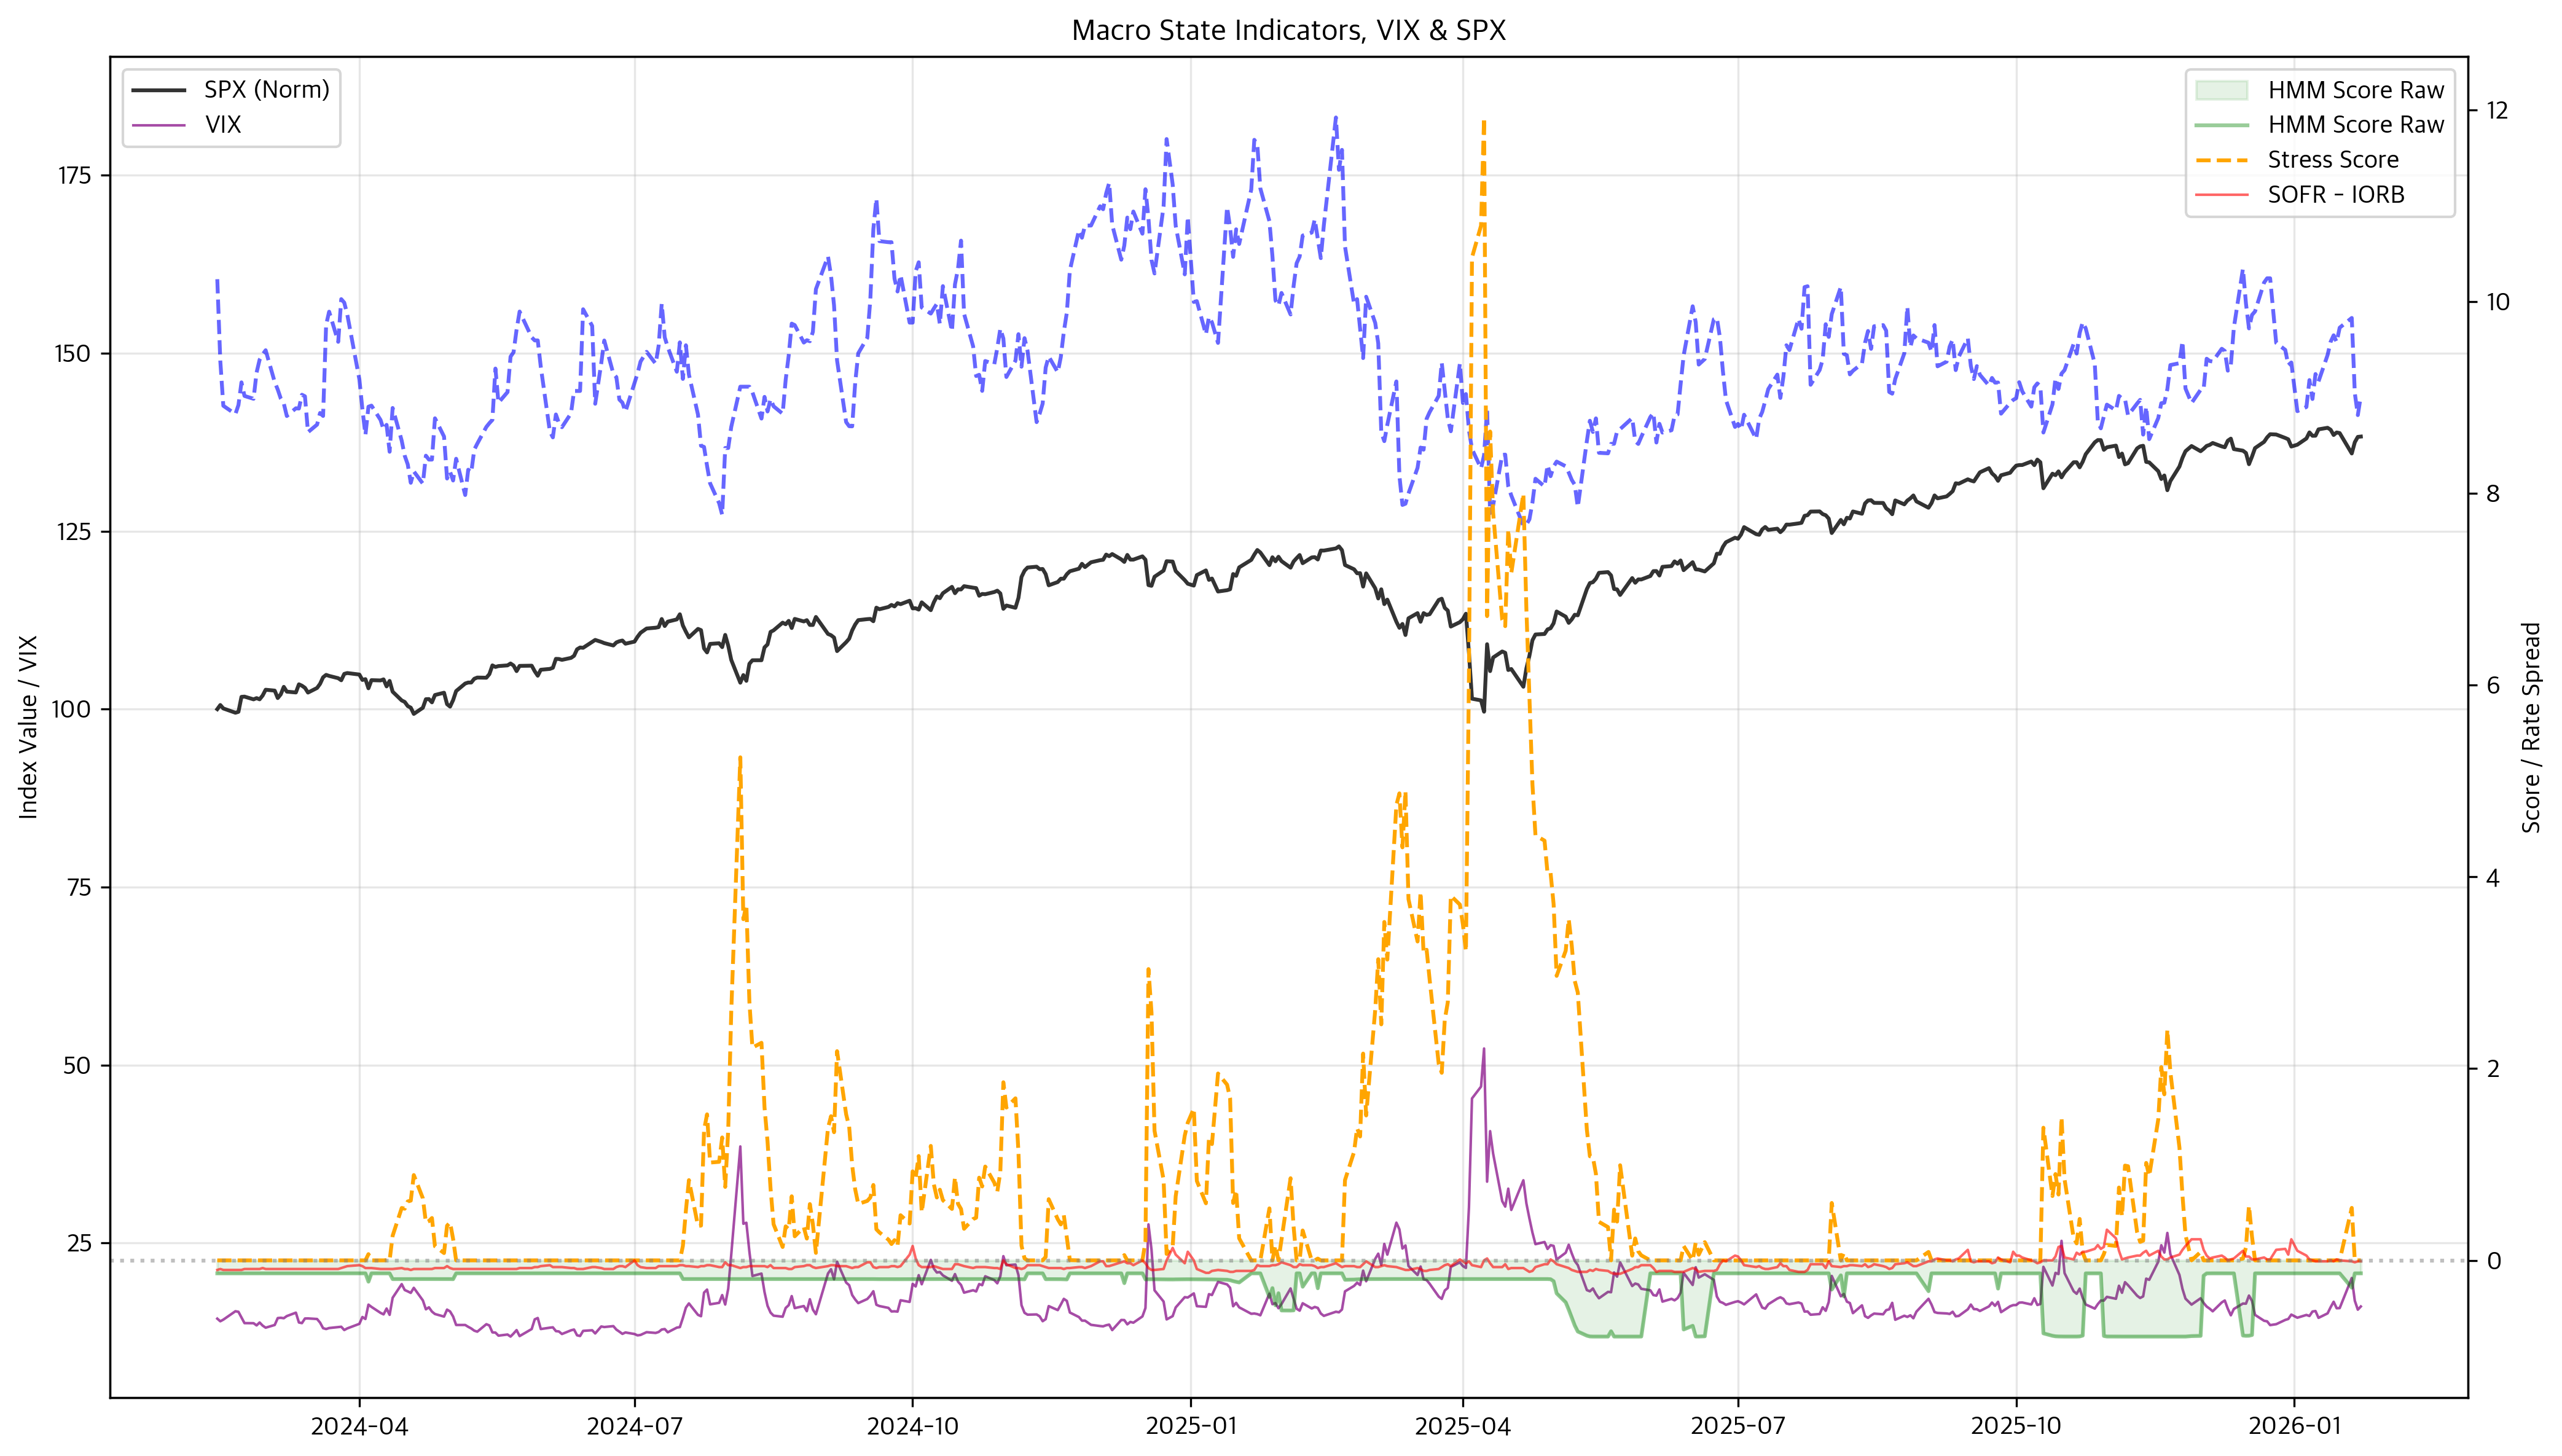

In [33]:
import matplotlib.pyplot as plt

# Ensure aligned data
if "hmm_score_raw" not in df.columns:
    print("Warning: New columns not found in df. Please re-run the fetch and join cells.")
else:
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Ax1: SPX (Norm) and VIX (Indices)
    ax1.plot(df.index, df["spx_norm"], label="SPX (Norm)", color="black", linewidth=1.5, alpha=0.8)
    if "vix" in df.columns:
        ax1.plot(df.index, df["vix"], label="VIX", color="purple", linewidth=1, alpha=0.7, linestyle='-')
    
    ax1.set_ylabel("Index Value / VIX")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Ax2: Scores and Rates
    ax2 = ax1.twinx()
    
    # HMM Score
    if "hmm_score_raw" in df.columns:
        ax2.fill_between(df.index, df["hmm_score_raw"], label="HMM Score Raw", color="green", alpha=0.1)
        ax2.plot(df.index, df["hmm_score_raw"], label="HMM Score Raw", color="green", alpha=0.4)

    # Stress Score
    if "stress_score" in df.columns:
        ax2.plot(df.index, df["stress_score"], label="Stress Score", color="orange", linewidth=1.5, linestyle="--")

    # SOFR-IORB
    if "sofr_minus_iorb" in df.columns:
        ax2.plot(df.index, df["sofr_minus_iorb"], label="SOFR - IORB", color="red", linewidth=1, alpha=0.6)
        ax2.axhline(0, color="gray", linestyle=":", alpha=0.5)

    # Skew (moved to Ax2 for scale maybe? No, Skew is ~100+, keep in Ax1? Skew is 100-150 usually. Normalized SPX is 100. VIX is 10-50. ) 
    # Let's keep Skew on Ax1 as requested previously, or maybe it fits better. 
    # Since SPX Norm ~100, Skew ~130, VIX ~20. VIX is the outlier on Ax1. 
    # But user asked to add VIX and Stress. Let's put Skew on Ax1 as it's an index. 
    # Actually Skew is closer to SPX Norm (100) than VIX (20). 
    # So: Ax1 = SPX, Skew. Ax2 = HMM, Stress, Rates, VIX? 
    # VIX is volatility, often inverse to SPX. 
    # Let's try putting VIX on Ax2 (right) or keep on Ax1 but realize the scale difference. 
    # Better: Ax1 (Left): SPX Norm, Skew. (Range 80-150)
    # Ax2 (Right): HMM Score (0-1), Stress (0-1?), SOFR-IORB (-0.1 to 0.1), VIX (10-30). 
    # Wait, HMM Score is prob raw, might be -inf to +inf or 0-1. "hmm_score_raw" sounds like log prob or similar. 
    # "stress_score" is likely normalized? 
    # If scales are vastly different, this single plot becomes messy. User asked to combine.
    # I will put VIX on Ax1 for now as it is a market index, although low value.
    # Or I can use a 3rd axis? Matplotlib allows it but might be complex.
    # Let's stick to Ax1: SPX, Skew. Ax2: HMM, Stress, SOFR-IORB. 
    # Where to put VIX? VIX is 10-40. SPX Norm is 100. Skew 120. 
    # VIX on Ax1 might flatten it. 
    # VIX on Ax2 (if scores are 0-1) might flatten scores. 
    # I will assume user wants to see timelines overlap. 
    # I will put VIX on Ax1. 

    if "skew" in df.columns:
        ax1.plot(df.index, df["skew"], label="Skew", color="blue", alpha=0.6, linestyle='--')

    ax2.set_ylabel("Score / Rate Spread")
    ax2.legend(loc="upper right")

    plt.title("Macro State Indicators, VIX & SPX")
    plt.tight_layout()
    plt.show()

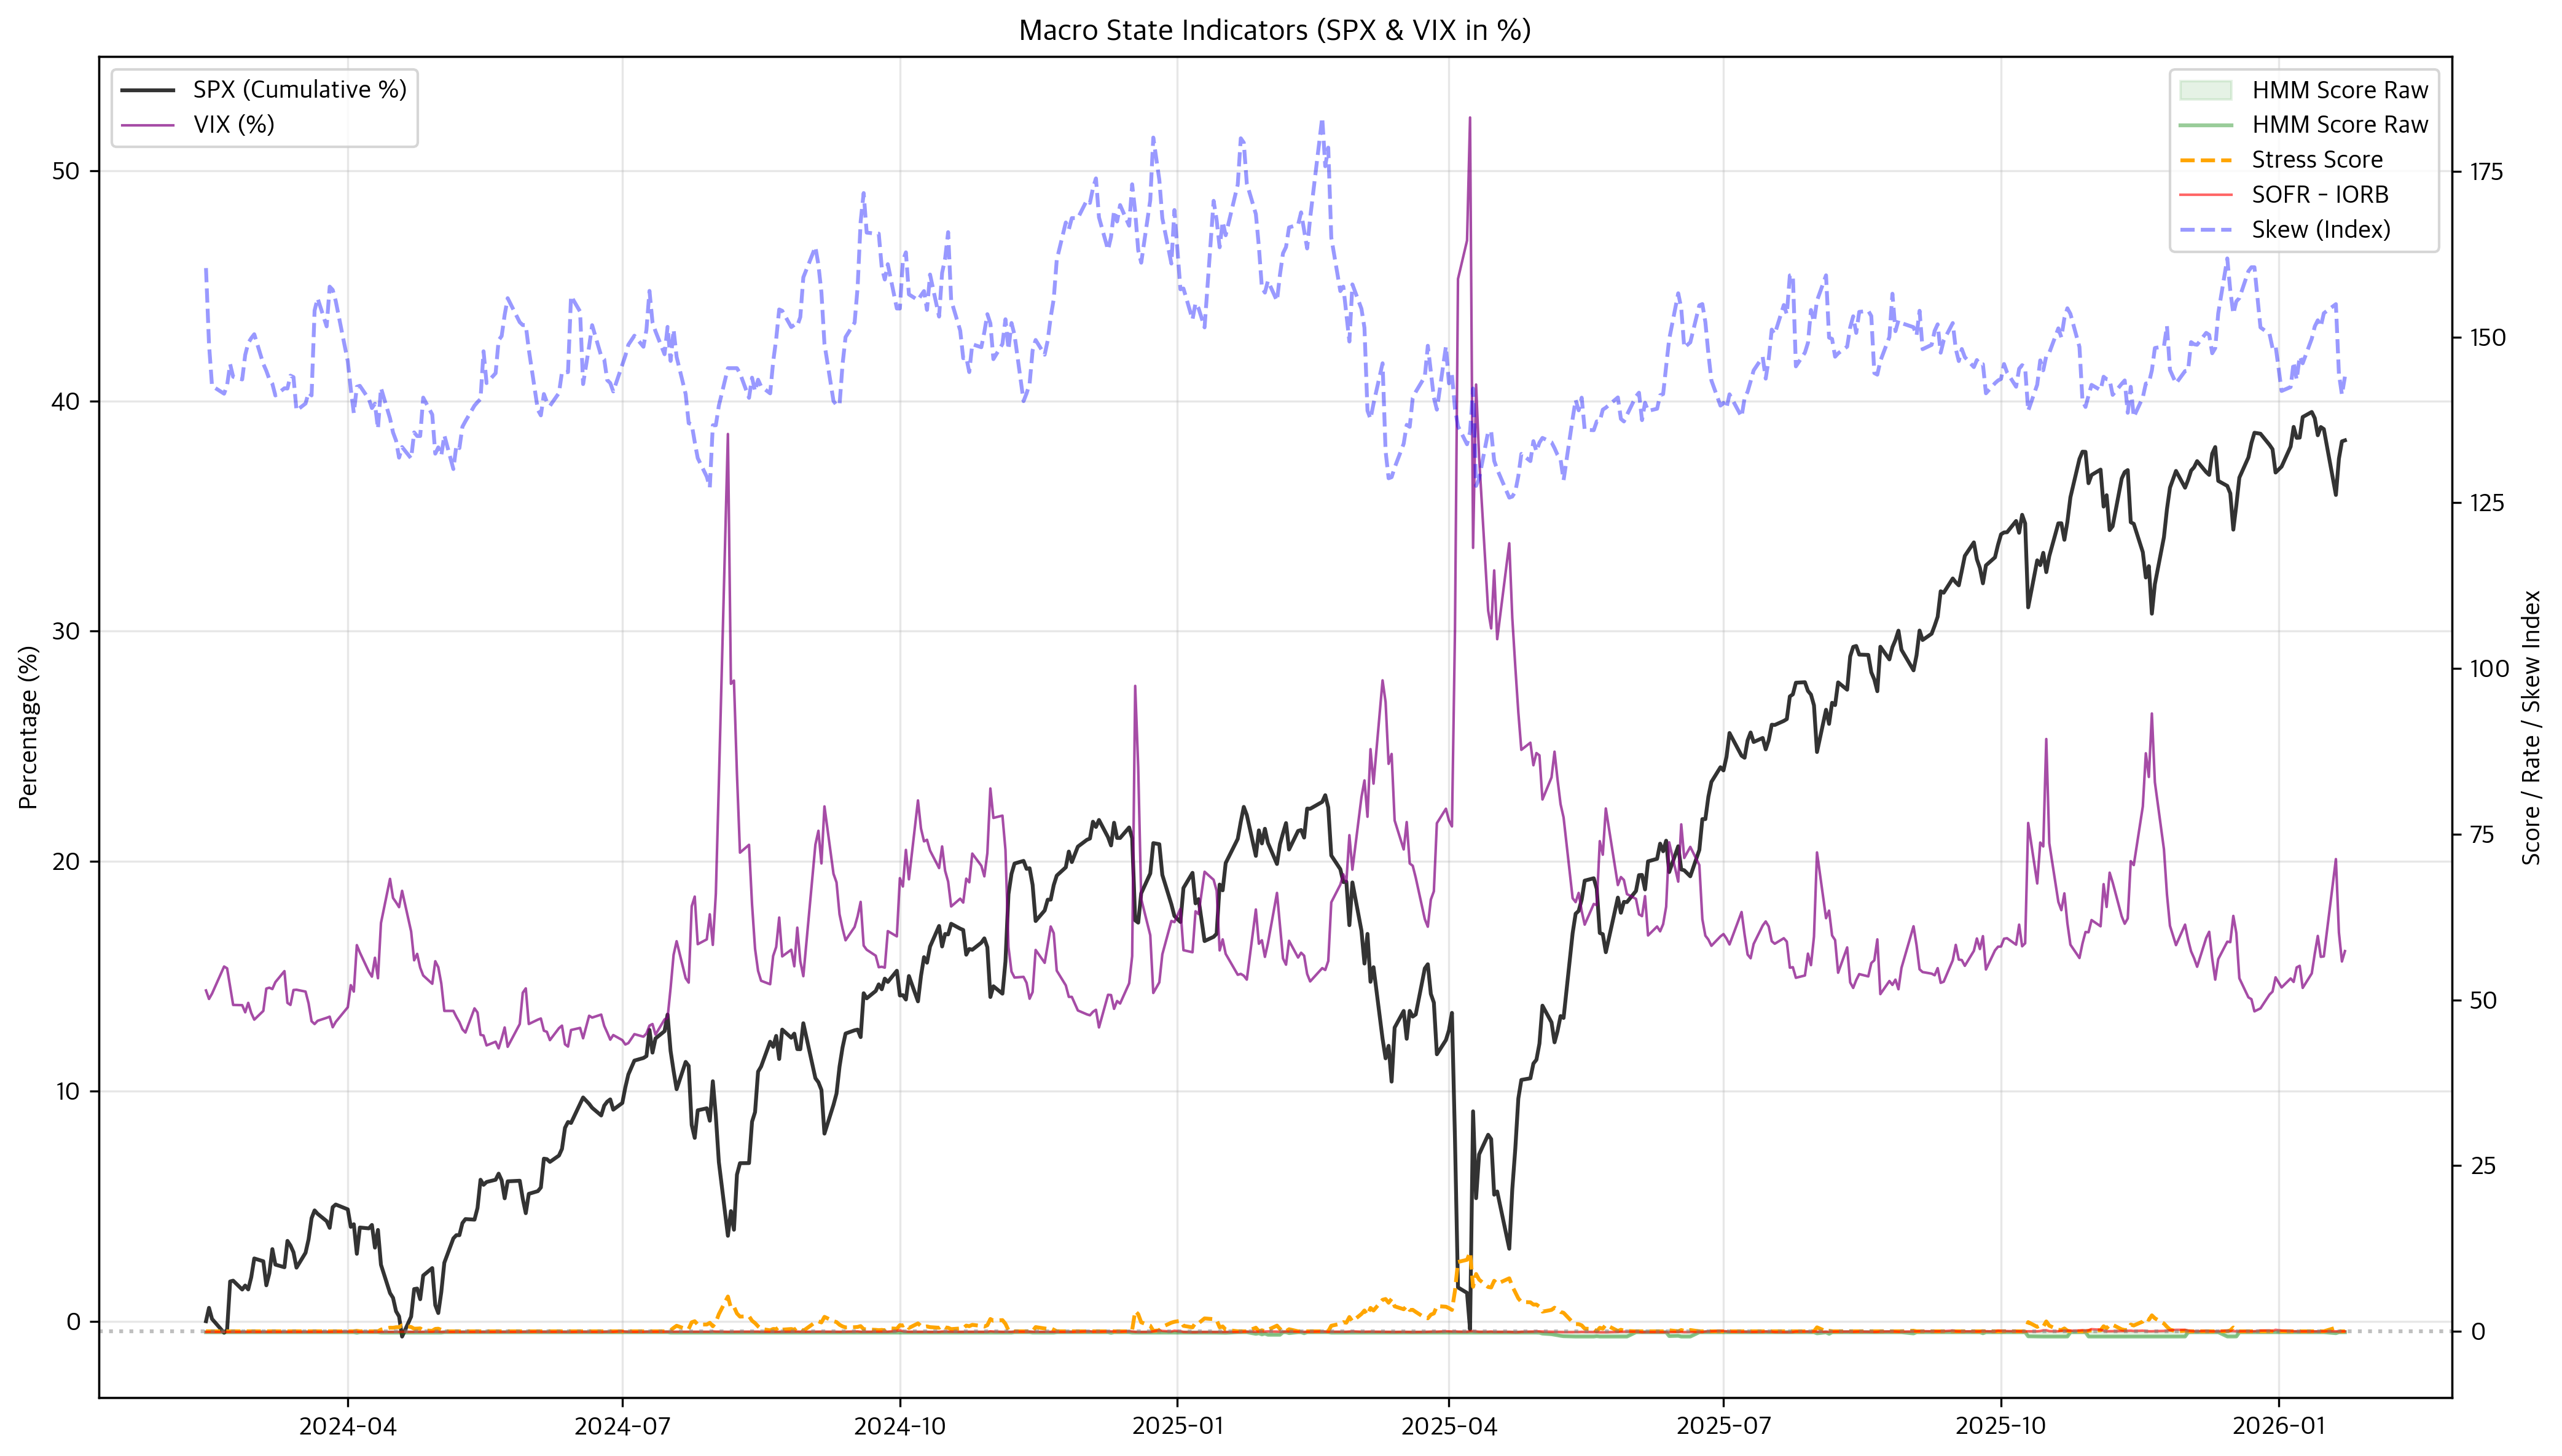

In [34]:
import matplotlib.pyplot as plt

# Ensure aligned data
if "hmm_score_raw" not in df.columns:
    print("Warning: New columns not found in df. Please re-run the fetch and join cells.")
else:
    # Calculate SPX Cumulative Return %
    # Assumes spx_norm is already normalized or raw price. 
    # If spx_norm is 100-based index, (val/100 - 1)*100 = val - 100. 
    # Safe way: pct indices.
    df["spx_pct"] = (df["spx_norm"] / df["spx_norm"].iloc[0] - 1) * 100

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Ax1: SPX (%) and VIX (%) 
    ax1.plot(df.index, df["spx_pct"], label="SPX (Cumulative %)", color="black", linewidth=1.5, alpha=0.8)
    if "vix" in df.columns:
        ax1.plot(df.index, df["vix"], label="VIX (%)", color="purple", linewidth=1, alpha=0.7, linestyle='-')
    
    ax1.set_ylabel("Percentage (%)")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Ax2: Scores and Rates
    ax2 = ax1.twinx()
    
    # HMM Score
    if "hmm_score_raw" in df.columns:
        ax2.fill_between(df.index, df["hmm_score_raw"], label="HMM Score Raw", color="green", alpha=0.1)
        ax2.plot(df.index, df["hmm_score_raw"], label="HMM Score Raw", color="green", alpha=0.4)

    # Stress Score
    if "stress_score" in df.columns:
        ax2.plot(df.index, df["stress_score"], label="Stress Score", color="orange", linewidth=1.5, linestyle="--")

    # SOFR-IORB
    if "sofr_minus_iorb" in df.columns:
        ax2.plot(df.index, df["sofr_minus_iorb"], label="SOFR - IORB", color="red", linewidth=1, alpha=0.6)
        ax2.axhline(0, color="gray", linestyle=":", alpha=0.5)

    if "skew" in df.columns:
        # Skew is strictly an index (~100-150), so percent might be misleading on Ax1 (which is now -20 to +50?).
        # But combining everything is requested. Skew at 140 on a % axis 0-50 squashes everything.
        # User emphasized VIX SPX percent. Skew might be better on secondary (scores)? 
        # Or just keep plotting it and let scale be what it is. 
        # I'll put Skew on Ax2 to avoid squashing SPX/VIX %.
        ax2.plot(df.index, df["skew"], label="Skew (Index)", color="blue", alpha=0.4, linestyle='--')

    ax2.set_ylabel("Score / Rate / Skew Index")
    ax2.legend(loc="upper right")

    plt.title("Macro State Indicators (SPX & VIX in %)")
    plt.tight_layout()
    plt.show()

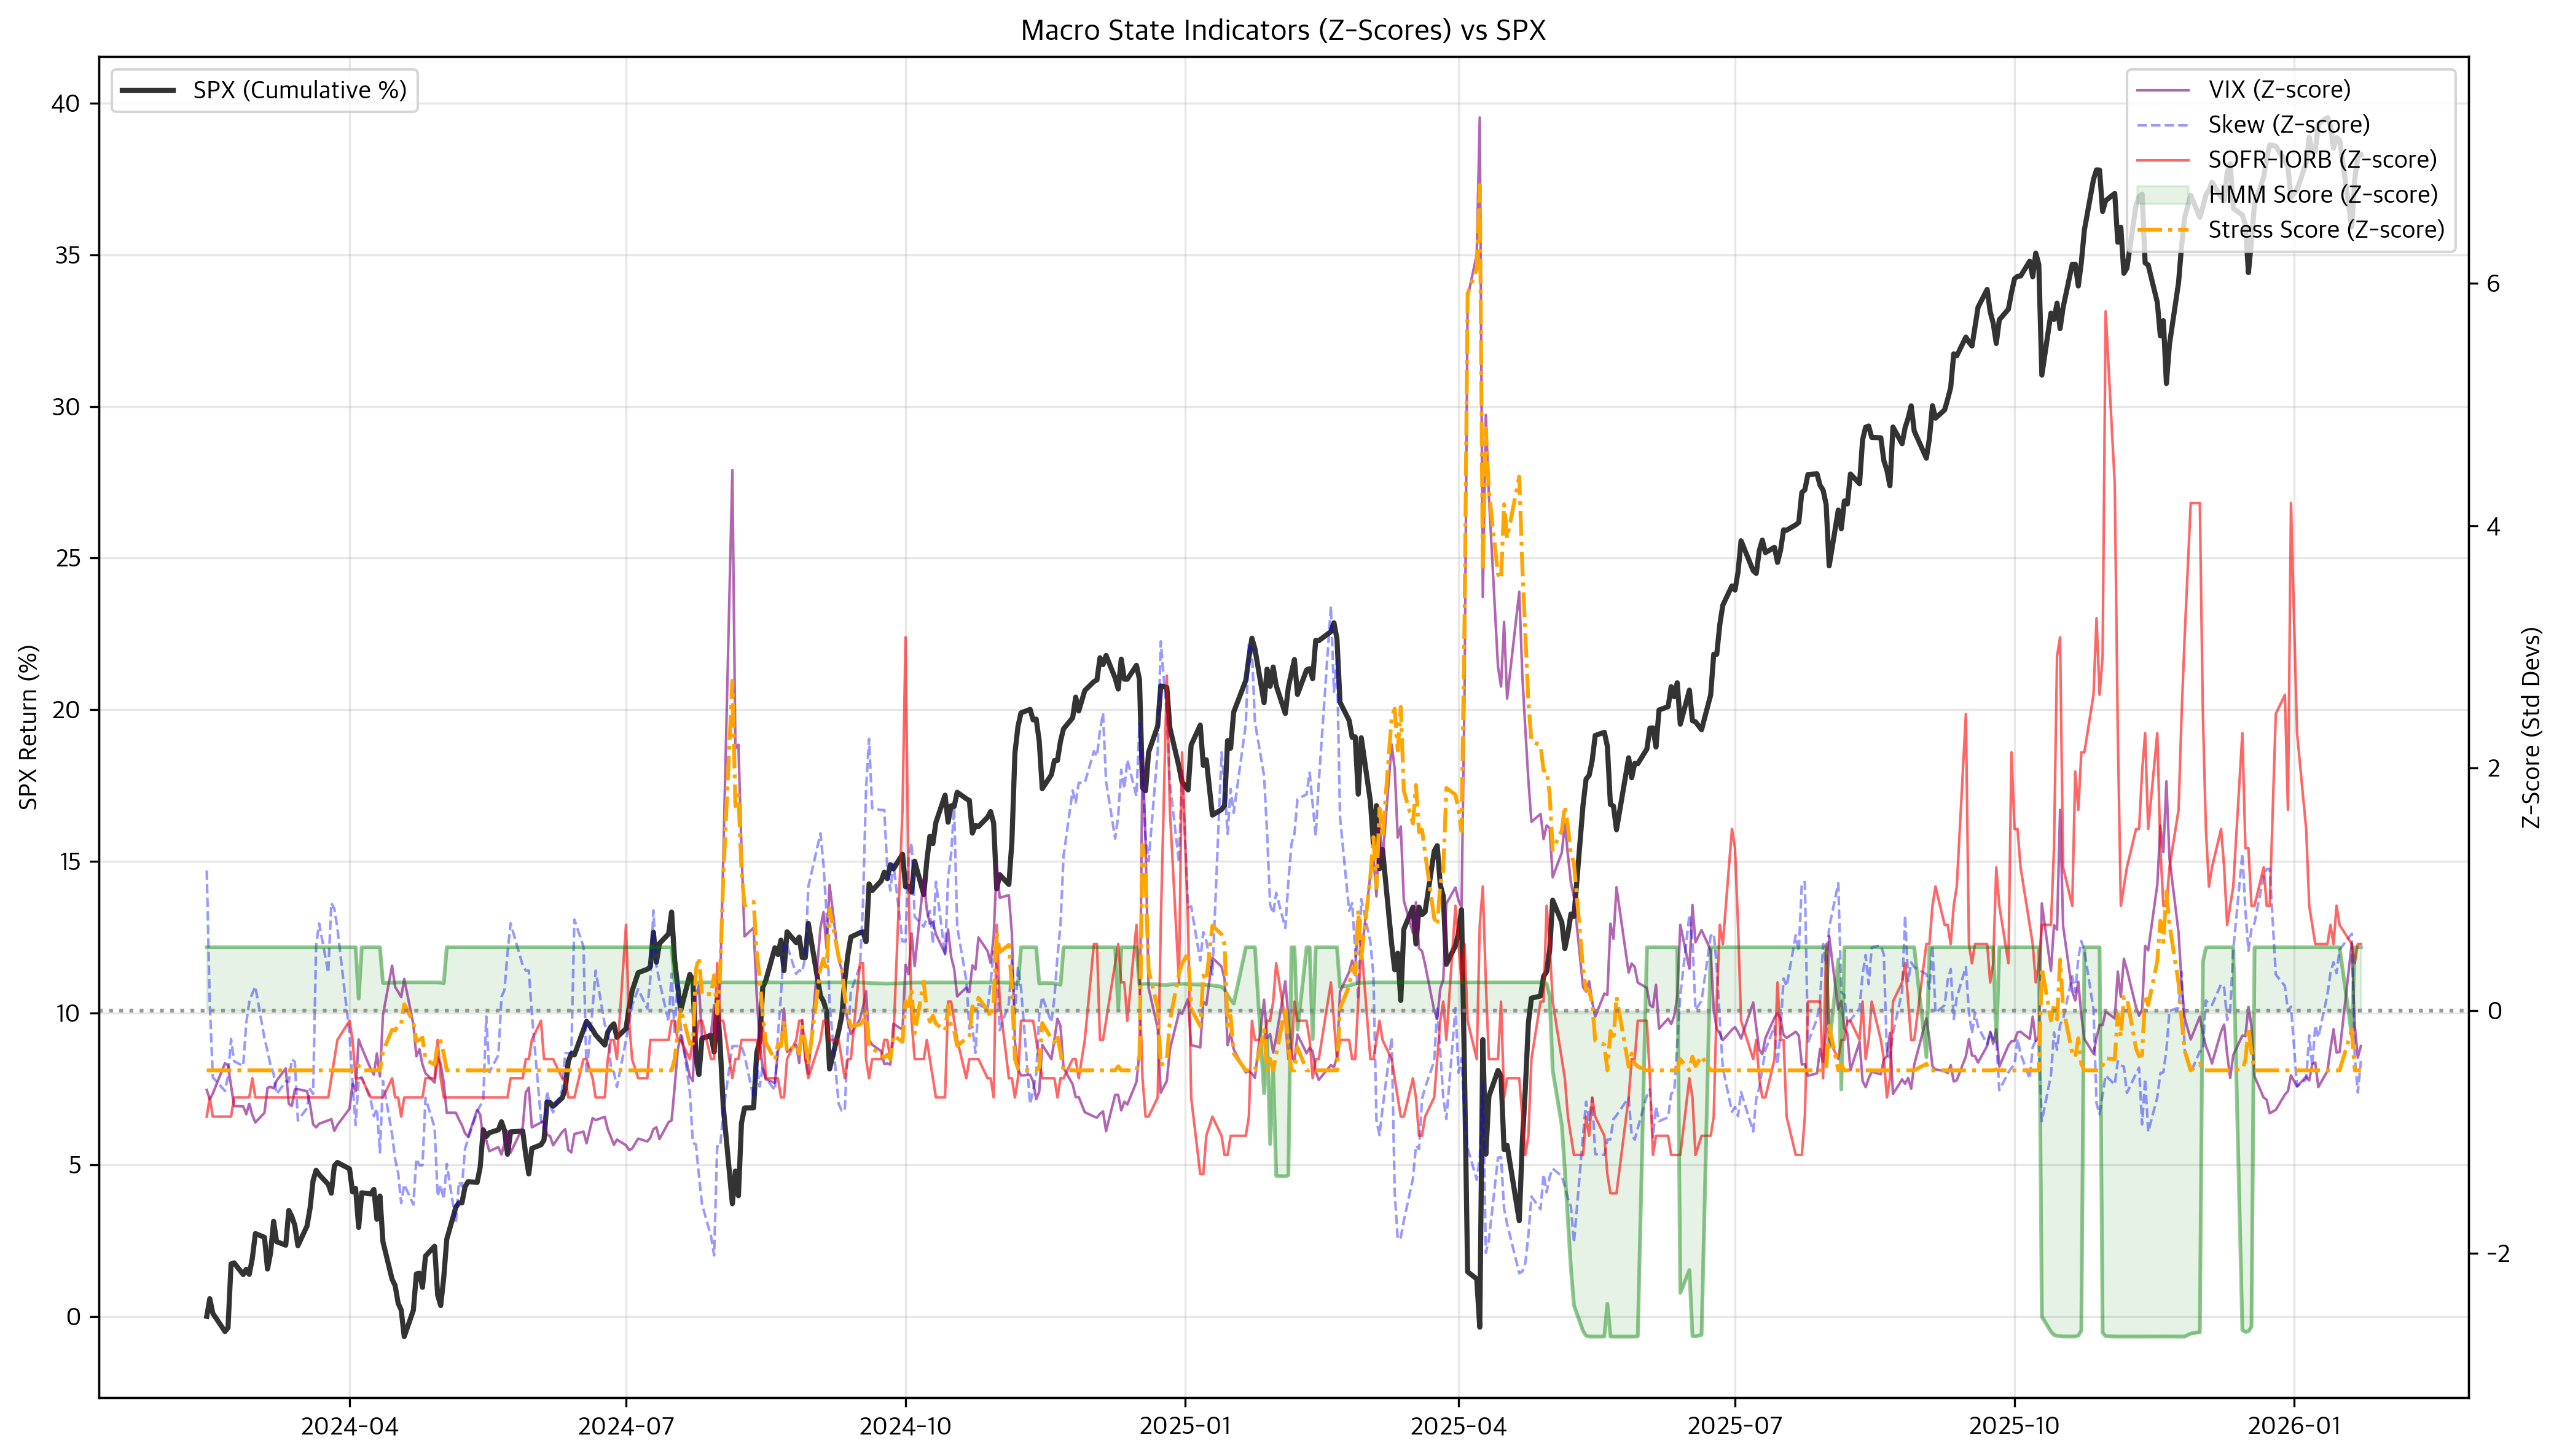

In [35]:
import matplotlib.pyplot as plt

# Ensure aligned data
if "hmm_score_raw" not in df.columns:
    print("Warning: New columns not found in df. Please re-run the fetch and join cells.")
else:
    # Calculate SPX Cumulative Return %
    df["spx_pct"] = (df["spx_norm"] / df["spx_norm"].iloc[0] - 1) * 100

    # Calculate Z-Scores for indicators
    cols_to_zscore = ["vix", "skew", "sofr_minus_iorb", "hmm_score_raw", "stress_score"]
    for col in cols_to_zscore:
        if col in df.columns:
            df[f"{col}_z"] = (df[col] - df[col].mean()) / df[col].std()

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Ax1: SPX (%)
    ax1.plot(df.index, df["spx_pct"], label="SPX (Cumulative %)", color="black", linewidth=2, alpha=0.8)
    ax1.set_ylabel("SPX Return (%)")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Ax2: Z-scores
    ax2 = ax1.twinx()
    
    # VIX Z-score
    if "vix_z" in df.columns:
        ax2.plot(df.index, df["vix_z"], label="VIX (Z-score)", color="purple", linewidth=1, alpha=0.6)

    # Skew Z-score
    if "skew_z" in df.columns:
        ax2.plot(df.index, df["skew_z"], label="Skew (Z-score)", color="blue", linewidth=1, alpha=0.4, linestyle="--")

    # SOFR-IORB Z-score
    if "sofr_minus_iorb_z" in df.columns:
        ax2.plot(df.index, df["sofr_minus_iorb_z"], label="SOFR-IORB (Z-score)", color="red", linewidth=1, alpha=0.6)

    # HMM Score Z-score
    if "hmm_score_raw_z" in df.columns:
        ax2.fill_between(df.index, df["hmm_score_raw_z"], label="HMM Score (Z-score)", color="green", alpha=0.1)
        ax2.plot(df.index, df["hmm_score_raw_z"], color="green", alpha=0.4)

    # Stress Score Z-score
    if "stress_score_z" in df.columns:
        ax2.plot(df.index, df["stress_score_z"], label="Stress Score (Z-score)", color="orange", linewidth=1.5, linestyle="-.")

    # Zero line for Z-scores
    ax2.axhline(0, color="gray", linestyle=":", alpha=0.8)
    ax2.set_ylabel("Z-Score (Std Devs)")
    ax2.legend(loc="upper right")

    plt.title("Macro State Indicators (Z-Scores) vs SPX")
    plt.tight_layout()
    plt.show()

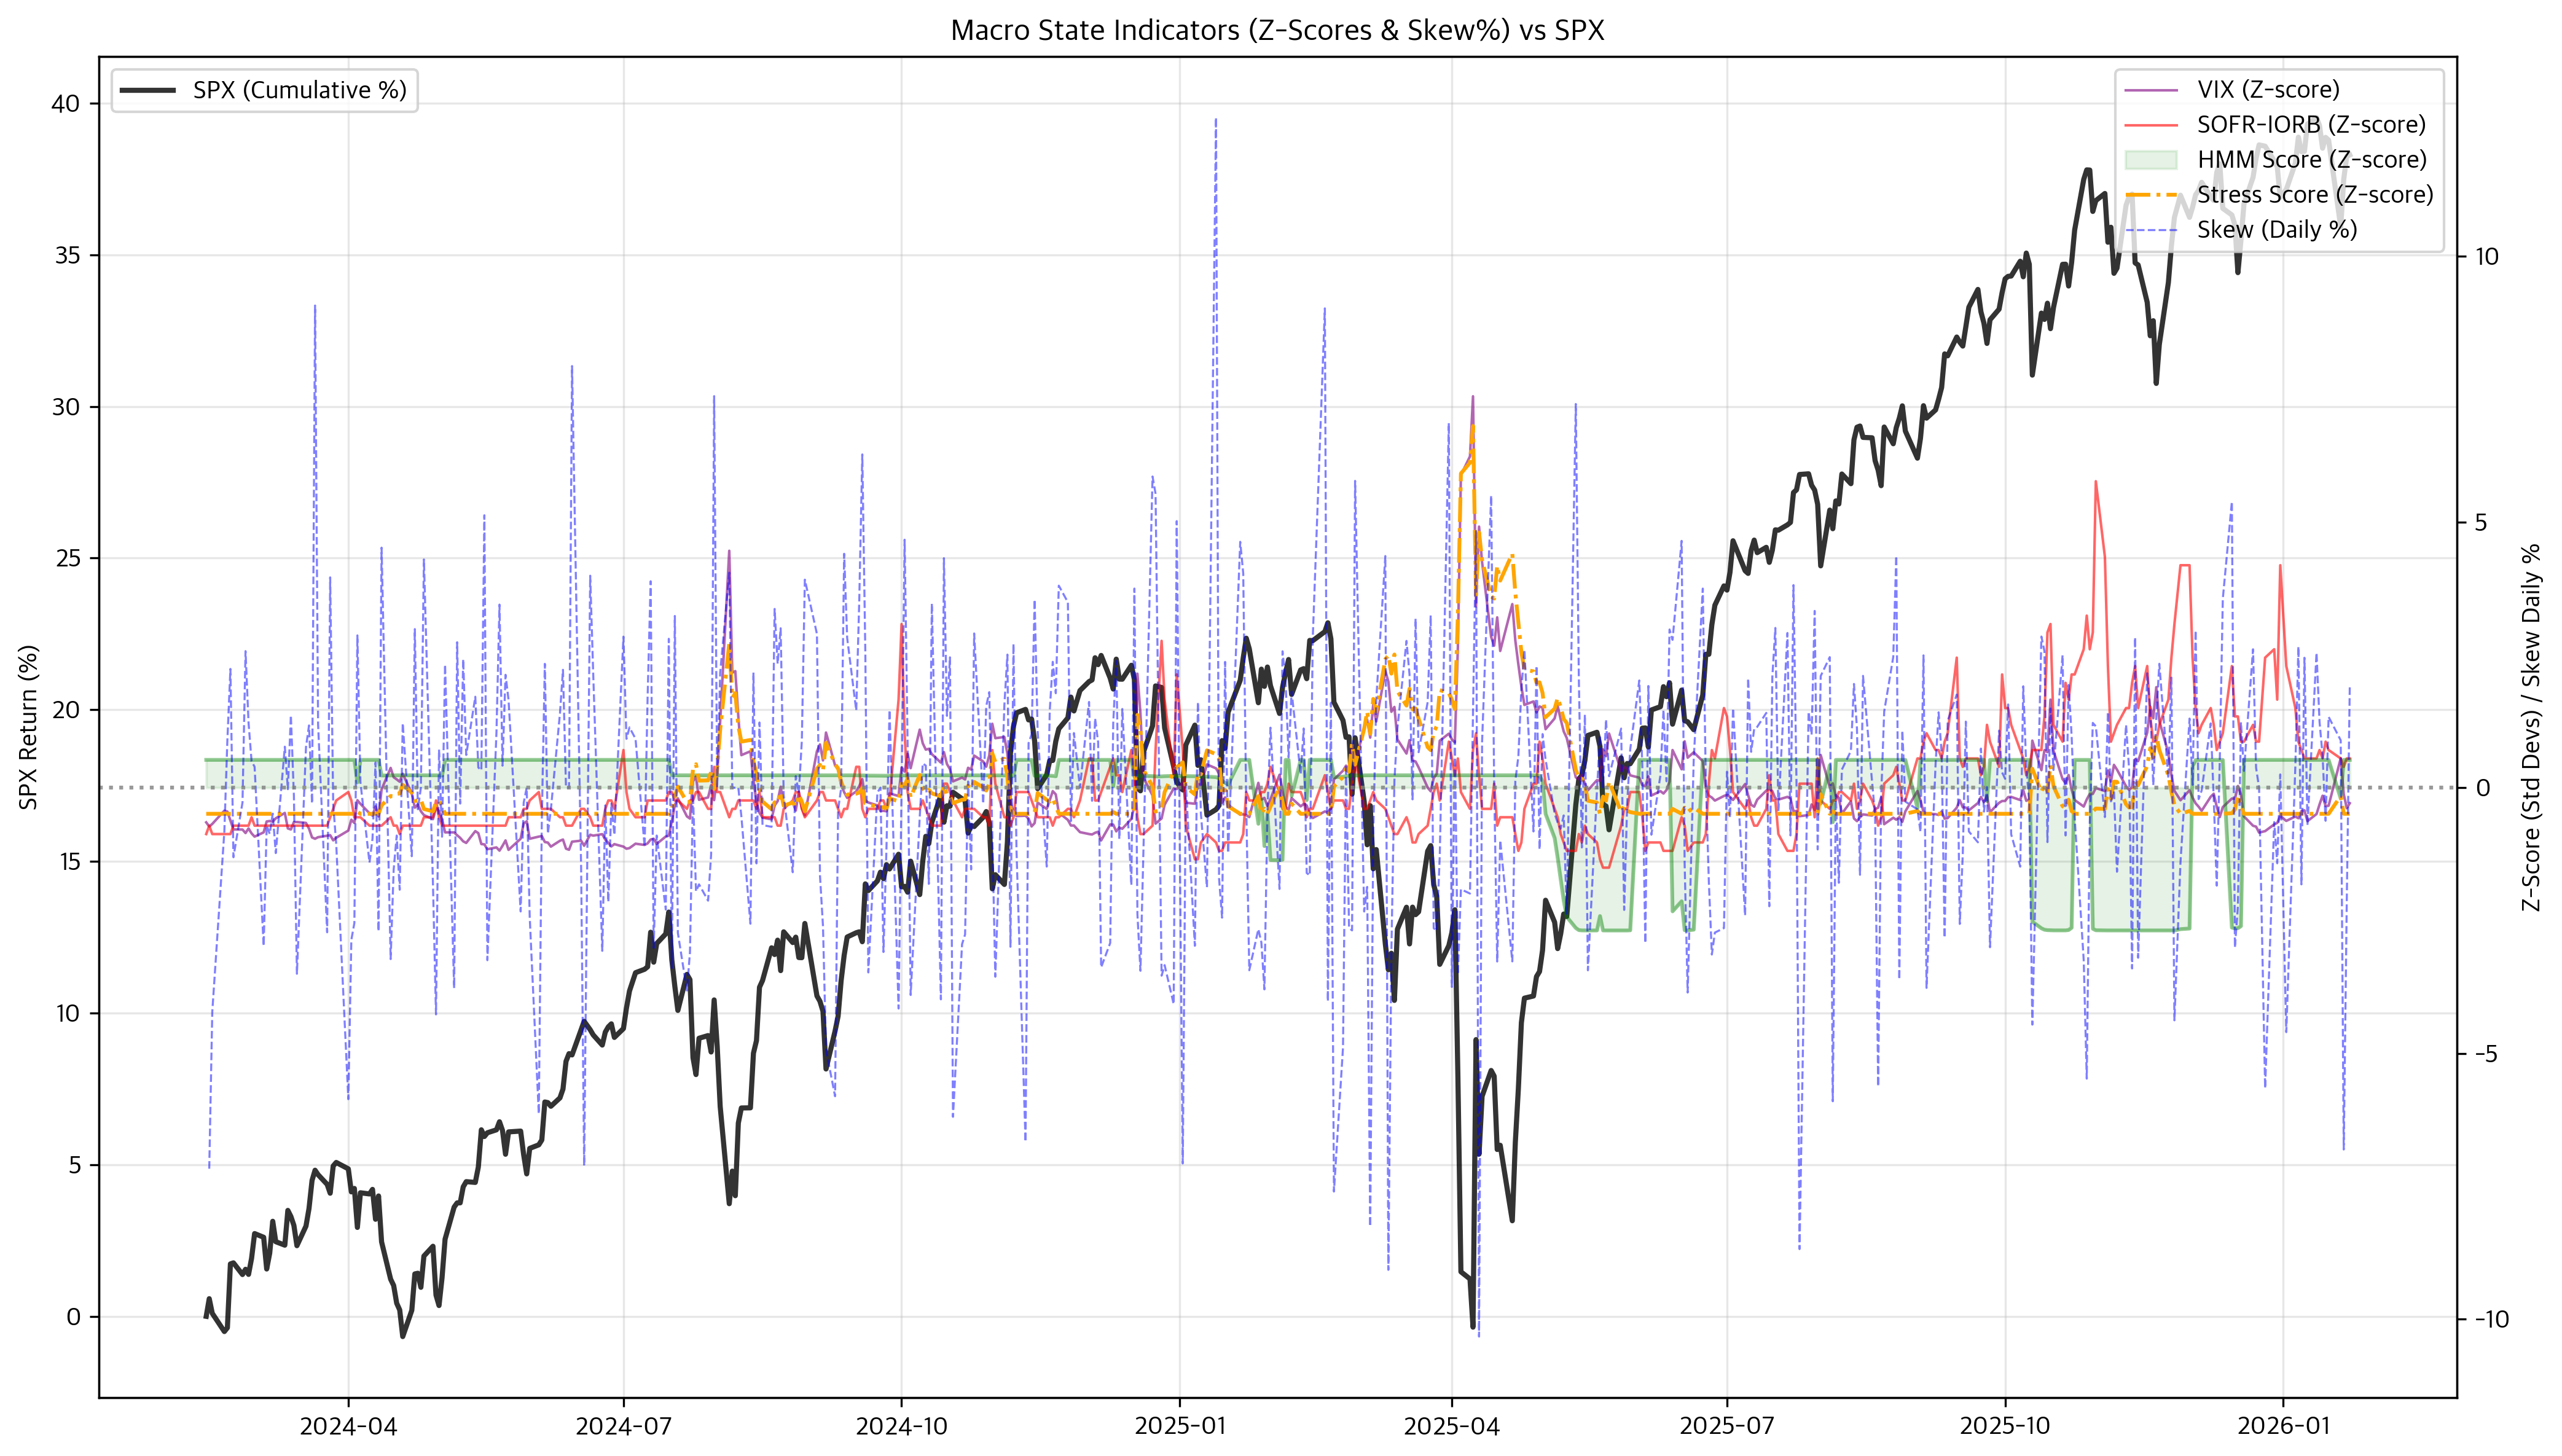

In [36]:
import matplotlib.pyplot as plt

# Ensure aligned data
if "hmm_score_raw" not in df.columns:
    print("Warning: New columns not found in df. Please re-run the fetch and join cells.")
else:
    # Calculate SPX Cumulative Return %
    df["spx_pct"] = (df["spx_norm"] / df["spx_norm"].iloc[0] - 1) * 100

    # Calculate Z-Scores for indicators (excluding Skew per request, excluding SPX)
    cols_to_zscore = ["vix", "sofr_minus_iorb", "hmm_score_raw", "stress_score"]
    for col in cols_to_zscore:
        if col in df.columns:
            df[f"{col}_z"] = (df[col] - df[col].mean()) / df[col].std()

    # Calculate Skew Daily Percentage Change
    if "skew" in df.columns:
        df["skew_daily_pct"] = df["skew"].pct_change() * 100

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Ax1: SPX (%)
    ax1.plot(df.index, df["spx_pct"], label="SPX (Cumulative %)", color="black", linewidth=2, alpha=0.8)
    ax1.set_ylabel("SPX Return (%)")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Ax2: Z-scores and Skew Daily Pct
    ax2 = ax1.twinx()
    
    # VIX Z-score
    if "vix_z" in df.columns:
        ax2.plot(df.index, df["vix_z"], label="VIX (Z-score)", color="purple", linewidth=1, alpha=0.6)

    # SOFR-IORB Z-score
    if "sofr_minus_iorb_z" in df.columns:
        ax2.plot(df.index, df["sofr_minus_iorb_z"], label="SOFR-IORB (Z-score)", color="red", linewidth=1, alpha=0.6)

    # HMM Score Z-score
    if "hmm_score_raw_z" in df.columns:
        ax2.fill_between(df.index, df["hmm_score_raw_z"], label="HMM Score (Z-score)", color="green", alpha=0.1)
        ax2.plot(df.index, df["hmm_score_raw_z"], color="green", alpha=0.4)

    # Stress Score Z-score
    if "stress_score_z" in df.columns:
        ax2.plot(df.index, df["stress_score_z"], label="Stress Score (Z-score)", color="orange", linewidth=1.5, linestyle="-.")

    # Skew Daily Percentage Change
    if "skew_daily_pct" in df.columns:
        # Use a lighter line as daily percent can be noisy
        ax2.plot(df.index, df["skew_daily_pct"], label="Skew (Daily %)", color="blue", linewidth=0.8, alpha=0.5, linestyle="--")

    # Zero line for Z-scores/Pct
    ax2.axhline(0, color="gray", linestyle=":", alpha=0.8)
    ax2.set_ylabel("Z-Score (Std Devs) / Skew Daily %")
    ax2.legend(loc="upper right")

    plt.title("Macro State Indicators (Z-Scores & Skew%) vs SPX")
    plt.tight_layout()
    plt.show()